In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv("smoke_detection.csv")
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


# 2. Data Cleaning & Preprocessing

## 2.1 Dataset Overview

In [23]:
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (62630, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [24]:
display(df.describe())
display(df.dtypes)
# check unique values in each column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,62630.000000,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,31314.500000,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,18079.868017,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,0.000000,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15657.250000,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,31314.500000,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,46971.750000,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,62629.000000,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


Unnamed: 0          int64
UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT                 int64
Fire Alarm          int64
dtype: object

Unnamed: 0: 62630 unique values
UTC: 62630 unique values
Temperature[C]: 21672 unique values
Humidity[%]: 3890 unique values
TVOC[ppb]: 1966 unique values
eCO2[ppm]: 1713 unique values
Raw H2: 1830 unique values
Raw Ethanol: 2659 unique values
Pressure[hPa]: 2213 unique values
PM1.0: 1337 unique values
PM2.5: 1351 unique values
NC0.5: 3093 unique values
NC1.0: 4113 unique values
NC2.5: 1161 unique values
CNT: 24994 unique values
Fire Alarm: 2 unique values


## 2.2 Missing Values Analysis

In [25]:
# check missing
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(missing_df['Column'], missing_df['Missing_Count'])
    plt.title('Missing Values Count')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.bar(missing_df['Column'], missing_df['Missing_Percentage'])
    plt.title('Missing Values Percentage')
    plt.xticks(rotation=45)
    plt.ylabel('Percentage (%)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

No missing values found in the dataset!


## 2.3 Duplicate Records Analysis

In [26]:
# Check duplicates
if df.duplicated().sum() > 0:
    print(f"\nDuplicate percentage: {(df.duplicated().sum() / len(df)) * 100:.2f}%")
    
    # Show some duplicate records
    print("\nSample duplicate records:")
    duplicates = df[df.duplicated(keep=False)].sort_values(df.columns.tolist())
    display(duplicates.head(10))
    
    # Remove duplicates
    df_cleaned = df.drop_duplicates()
    print(f"\nAfter removing duplicates:")
    print(f"Records removed: {len(df) - len(df_cleaned)}")
    print(f"Remaining records: {len(df_cleaned)}")
    
else:
    print("No duplicate records found!")
    df_cleaned = df.copy()

No duplicate records found!


## 2.4 Feature Analysis and Selection

In [27]:
# examine each column
feature_analysis = []
for col in df_cleaned.columns:
    unique_vals = df_cleaned[col].nunique()
    unique_ratio = unique_vals / len(df_cleaned)
    data_type = df_cleaned[col].dtype 
    
    feature_analysis.append({
        'Feature': col,
        'Data_Type': data_type,
        'Unique_Values': unique_vals,
        'Unique_Ratio': unique_ratio,
        'Min': df_cleaned[col].min() if data_type in ['int64', 'float64'] else 'N/A',
        'Max': df_cleaned[col].max() if data_type in ['int64', 'float64'] else 'N/A'
    })

feature_df = pd.DataFrame(feature_analysis)
display(feature_df)

# 1. Check for constant features
features_to_remove = []
constant_features = feature_df[feature_df['Unique_Values'] <= 1]['Feature'].tolist()
if constant_features:
    print(f"Constant features (to remove): {constant_features}")
    features_to_remove.extend(constant_features)

# 2. Check for unique identifier columns (like UTC timestamp)
features_to_remove = []
unique_features = feature_df[feature_df['Unique_Ratio'] >= 0.95]['Feature'].tolist()
if unique_features:
    print(f"unique features (to remove): {unique_features}")
    features_to_remove.extend(unique_features)

# done
features_to_remove = list(set(features_to_remove))  # remove duplicates
print(f"\nRecommended features for removal: {features_to_remove}")

if features_to_remove:
    df_final = df_cleaned.drop(columns=features_to_remove)
    print(f"\nDataset shape after feature removal: {df_final.shape}")
else:
    df_final = df_cleaned.copy()
    print(f"\nNo features removed. Dataset shape: {df_final.shape}")

,Feature,Data_Type,Unique_Values,Unique_Ratio,Min,Max
0,Unnamed: 0,int64,62630,1.000000,0.000000e+00,6.262900e+04
1,UTC,int64,62630,1.000000,1.654712e+09,1.655130e+09
2,Temperature[C],float64,21672,0.346032,-2.201000e+01,5.993000e+01
3,Humidity[%],float64,3890,0.062111,1.074000e+01,7.520000e+01
4,TVOC[ppb],int64,1966,0.031391,0.000000e+00,6.000000e+04
5,eCO2[ppm],int64,1713,0.027351,4.000000e+02,6.000000e+04
6,Raw H2,int64,1830,0.029219,1.066800e+04,1.380300e+04
7,Raw Ethanol,int64,2659,0.042456,1.531700e+04,2.141000e+04
8,Pressure[hPa],float64,2213,0.035335,9.308520e+02,9.398610e+02
9,PM1.0,float64,1337,0.021348,0.000000e+00,1.433369e+04


unique features (to remove): ['Unnamed: 0', 'UTC']

Recommended features for removal: ['Unnamed: 0', 'UTC']

Dataset shape after feature removal: (62630, 14)


## 2.5 Correlation Analysis

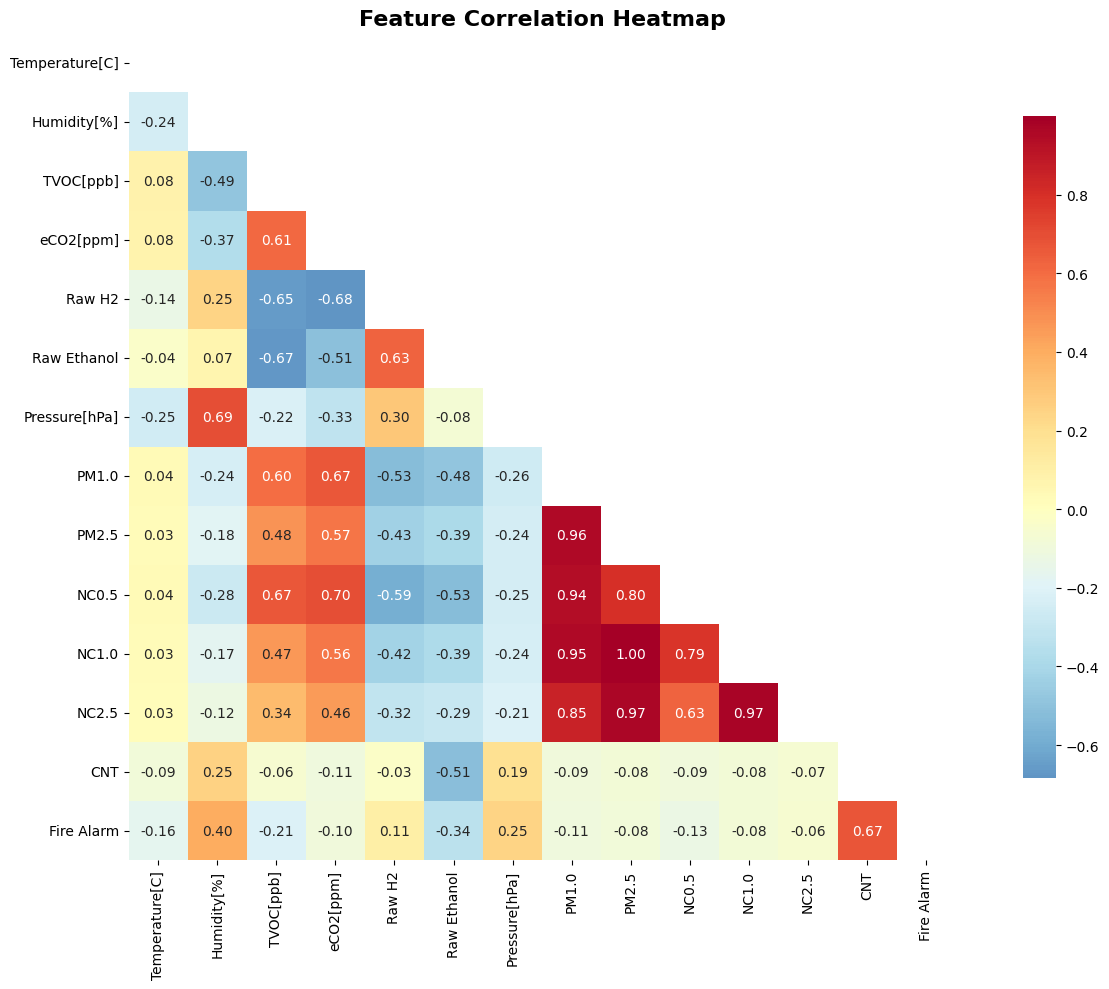

High Correlation Pairs (|correlation| >: 0.95)


,Feature_1,Feature_2,Correlation
1,PM2.5,NC1.0,0.999787
3,NC1.0,NC2.5,0.974249
2,PM2.5,NC2.5,0.969382
0,PM1.0,PM2.5,0.956118


Features to remove due to high correlation: ['PM2.5', 'NC2.5', 'NC1.0']


In [28]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
correlation_matrix = df_final[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            mask=mask)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_threshold = 0.95
print(f"High Correlation Pairs (|correlation| >: {high_corr_threshold})")
print("="*50)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    display(high_corr_df)

    # Remove one of each pair of highly correlated features
    features_to_remove = high_corr_df['Feature_2'].tolist()
    features_to_remove = list(set(features_to_remove))  # remove duplicates
    print(f"Features to remove due to high correlation: {features_to_remove}")
    df_final = df_final.drop(columns=features_to_remove)
else:
    print(f"No highly correlated feature pairs found (|correlation| >: {high_corr_threshold})")

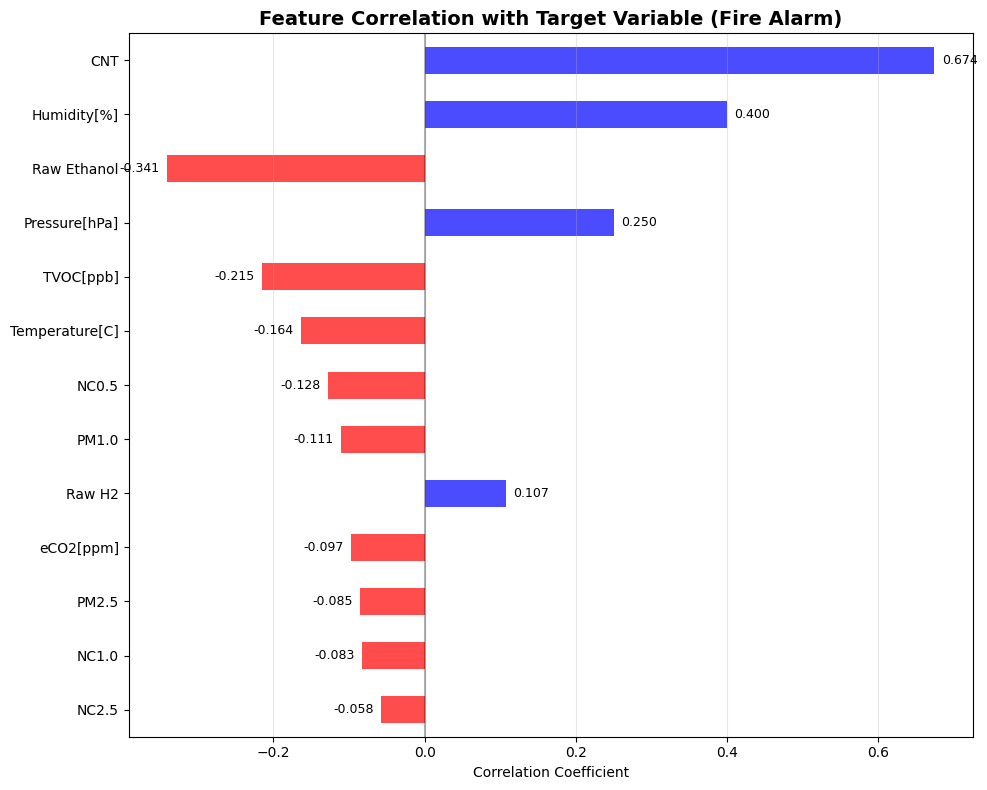

Top 5 features most correlated with Fire Alarm:
  CNT: 0.674
  Humidity[%]: 0.400
  Raw Ethanol: -0.341
  Pressure[hPa]: 0.250
  TVOC[ppb]: -0.215


In [29]:
# Correlation with target variable (horizontal bar chart)
target_col = 'Fire Alarm'
if target_col in df_final.columns:
    target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=True)
    
    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'blue' for x in target_correlations]
    target_correlations.plot(kind='barh', color=colors, alpha=0.7)
    plt.title(f'Feature Correlation with Target Variable ({target_col})', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.grid(axis='x', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add correlation values as text
    for i, v in enumerate(target_correlations):
        plt.text(v + 0.01 if v >= 0 else v - 0.01, i, f'{v:.3f}', 
                va='center', ha='left' if v >= 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("Top 5 features most correlated with Fire Alarm:")
    top_corr = target_correlations.abs().nlargest(5)
    for feature, corr in top_corr.items():
        actual_corr = target_correlations[feature]
        print(f"  {feature}: {actual_corr:.3f}")

    # we can consider removing features with very low correlation with target
    low_corr_threshold = 0.05
    low_corr_features = target_correlations[abs(target_correlations) < low_corr_threshold].index.tolist()
    if low_corr_features:
        print(f"\nFeatures with low correlation to target (|correlation| < {low_corr_threshold}): {low_corr_features}")
        df_final = df_final.drop(columns=low_corr_features)
        print(f"Dataset shape after removing low-correlation features: {df_final.shape}")
else:
    print("Target variable not found for correlation analysis")

In [30]:
df_final.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,NC0.5,CNT,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,1,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,2,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,3,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,4,0


## Tricky Note:

In [31]:
# the column CNT is similar to index, so we can remove it
# monitor it, very wide range with fake correlation to the target
# it counts from 0 to around 25000 then resets 
if 'CNT' in df_final.columns:
    df_final = df_final.drop(columns=['CNT'])
    print(f"Removed 'CNT' column. Dataset shape: {df_final.shape}")

Removed 'CNT' column. Dataset shape: (62630, 10)


# 3. Feature Engineering & Transformation

## 3.1 Create New Features

In [32]:
df_engineered = df_final.copy()

# 1. PM (Particulate Matter) composite feature, it will be skipped as we droppped one of them
if all(col in df_engineered.columns for col in ['PM1.0', 'PM2.5']) and 'PM_Total' not in df_engineered.columns:
    df_engineered['PM_Total'] = df_engineered['PM1.0'] + df_engineered['PM2.5']
    df_engineered['PM_Ratio'] = df_engineered['PM2.5'] / (df_engineered['PM1.0'] + 1e-6)  # Add small value to avoid division by zero
    print("Created PM_Total and PM_Ratio features")

# 2. NC (Number Concentration) composite features, it will be skipped as we droppped one of them
nc_cols = [col for col in df_engineered.columns if col.startswith('NC')]
if len(nc_cols) > 1:
    df_engineered['NC_Total'] = df_engineered[nc_cols].sum(axis=1)
    df_engineered['NC_Weighted'] = (df_engineered['NC0.5'] * 0.5 + 
                                   df_engineered['NC1.0'] * 1.0 + 
                                   df_engineered['NC2.5'] * 2.5) if all(col in df_engineered.columns for col in ['NC0.5', 'NC1.0', 'NC2.5']) else 0
    print("Created NC_Total and NC_Weighted features")

# 3. Categorize temperature into bins
if 'Temperature[C]' in df_engineered.columns and 'Temp_Category' not in df_engineered.columns:
    df_engineered['Temp_Category'] = pd.cut(df_engineered['Temperature[C]'], 
                                           bins=[0, 18, 22, 26, 100], 
                                           labels=['Cold', 'Moderate', 'Warm', 'Hot'])
    print("Created Temp_Category feature")

# 4. Categorize humidity into bins
if 'Humidity[%]' in df_engineered.columns and 'Humidity_Category' not in df_engineered.columns:
    df_engineered['Humidity_Category'] = pd.cut(df_engineered['Humidity[%]'], 
                                               bins=[0, 30, 50, 70, 100], 
                                               labels=['Low', 'Moderate', 'High', 'Very_High'])
    print("Created Humidity_Category feature")

new_features = [col for col in df_engineered.columns if col not in df_final.columns]
if new_features:
    print(f"\nNew features created: {new_features}")
else :
    print("No new features were created.")

Created Temp_Category feature
Created Humidity_Category feature

New features created: ['Temp_Category', 'Humidity_Category']


## 3.2 Feature Scaling and Transformation

In [43]:
target_col = 'Fire Alarm'
categorical_cols = df_engineered.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()

# remove target from numerical
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

df_transformed = df_engineered.copy()

# encode
label_encoders = {}
for col in categorical_cols:
    if col != target_col:  # Don't encode target if it's categorical
        le = LabelEncoder()
        df_transformed[col + '_encoded'] = le.fit_transform(df_transformed[col].astype(str))
        label_encoders[col] = le
        print(f"Label encoded: {col}")

# Define features with extreme outliers that need robust scaling
outlier_features = ['TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']
outlier_features_available = [col for col in outlier_features if col in df_transformed.columns]

# Define regular numerical features for standard scaling
regular_features = [col for col in numerical_cols if col in df_transformed.columns and col not in outlier_features_available]

# Apply RobustScaler to outlier-prone features
if outlier_features_available:
    robust_scaler = RobustScaler()
    df_transformed[outlier_features_available] = robust_scaler.fit_transform(df_transformed[outlier_features_available])
    print(f"Robust scaled {len(outlier_features_available)} outlier-prone features: {outlier_features_available}")

# Apply StandardScaler to regular features
if regular_features:
    standard_scaler = StandardScaler()
    df_transformed[regular_features] = standard_scaler.fit_transform(df_transformed[regular_features])
    print(f"Standard scaled {len(regular_features)} regular features")

# return back to final dataset
df_final = df_transformed.copy()
print(f"\nFinal dataset shape: {df_final.shape}")

Numerical features: 9
Categorical features: 0
Robust scaled 4 outlier-prone features: ['TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']
Standard scaled 5 regular features

Final dataset shape: (62630, 12)


# 4. EDA

## 4.1 Target Variable Analysis

  Fire Detected (Class 1): 44757 samples
  No Fire (Class 0): 17873 samples


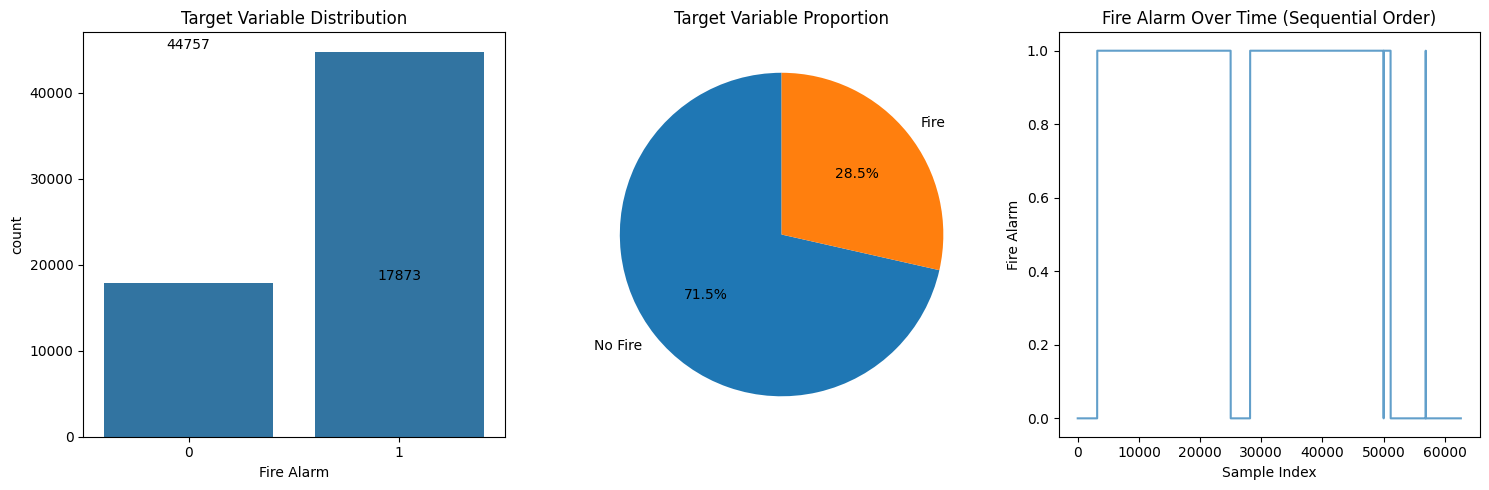

In [34]:
target_col = 'Fire Alarm'
if target_col in df_engineered.columns:
    # Basic statistics
    target_counts = df_engineered[target_col].value_counts()
    for i, (count) in enumerate(target_counts):
        class_name = "No Fire" if target_counts.index[i] == 0 else "Fire Detected"
        print(f"  {class_name} (Class {target_counts.index[i]}): {count} samples")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.countplot(data=df_engineered, x=target_col, ax=axes[0])
    axes[0].set_title('Target Variable Distribution')
    axes[0].set_xlabel('Fire Alarm')
    for i, v in enumerate(target_counts):
        axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom')

    axes[1].pie(target_counts.values, labels=['No Fire', 'Fire'], autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Target Variable Proportion')
    
    # Time series view (if we have enough sequential data)
    axes[2].plot(df_engineered.index, df_engineered[target_col], alpha=0.7)
    axes[2].set_title('Fire Alarm Over Time (Sequential Order)')
    axes[2].set_xlabel('Sample Index')
    axes[2].set_ylabel('Fire Alarm')
    
    plt.tight_layout()
    plt.show()
else:
    print("Target variable not found!")

## 4.2 Feature Distributions

In [35]:
numeric_features = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)

key_features = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']
available_key_features = [f for f in key_features if f in df_engineered.columns]


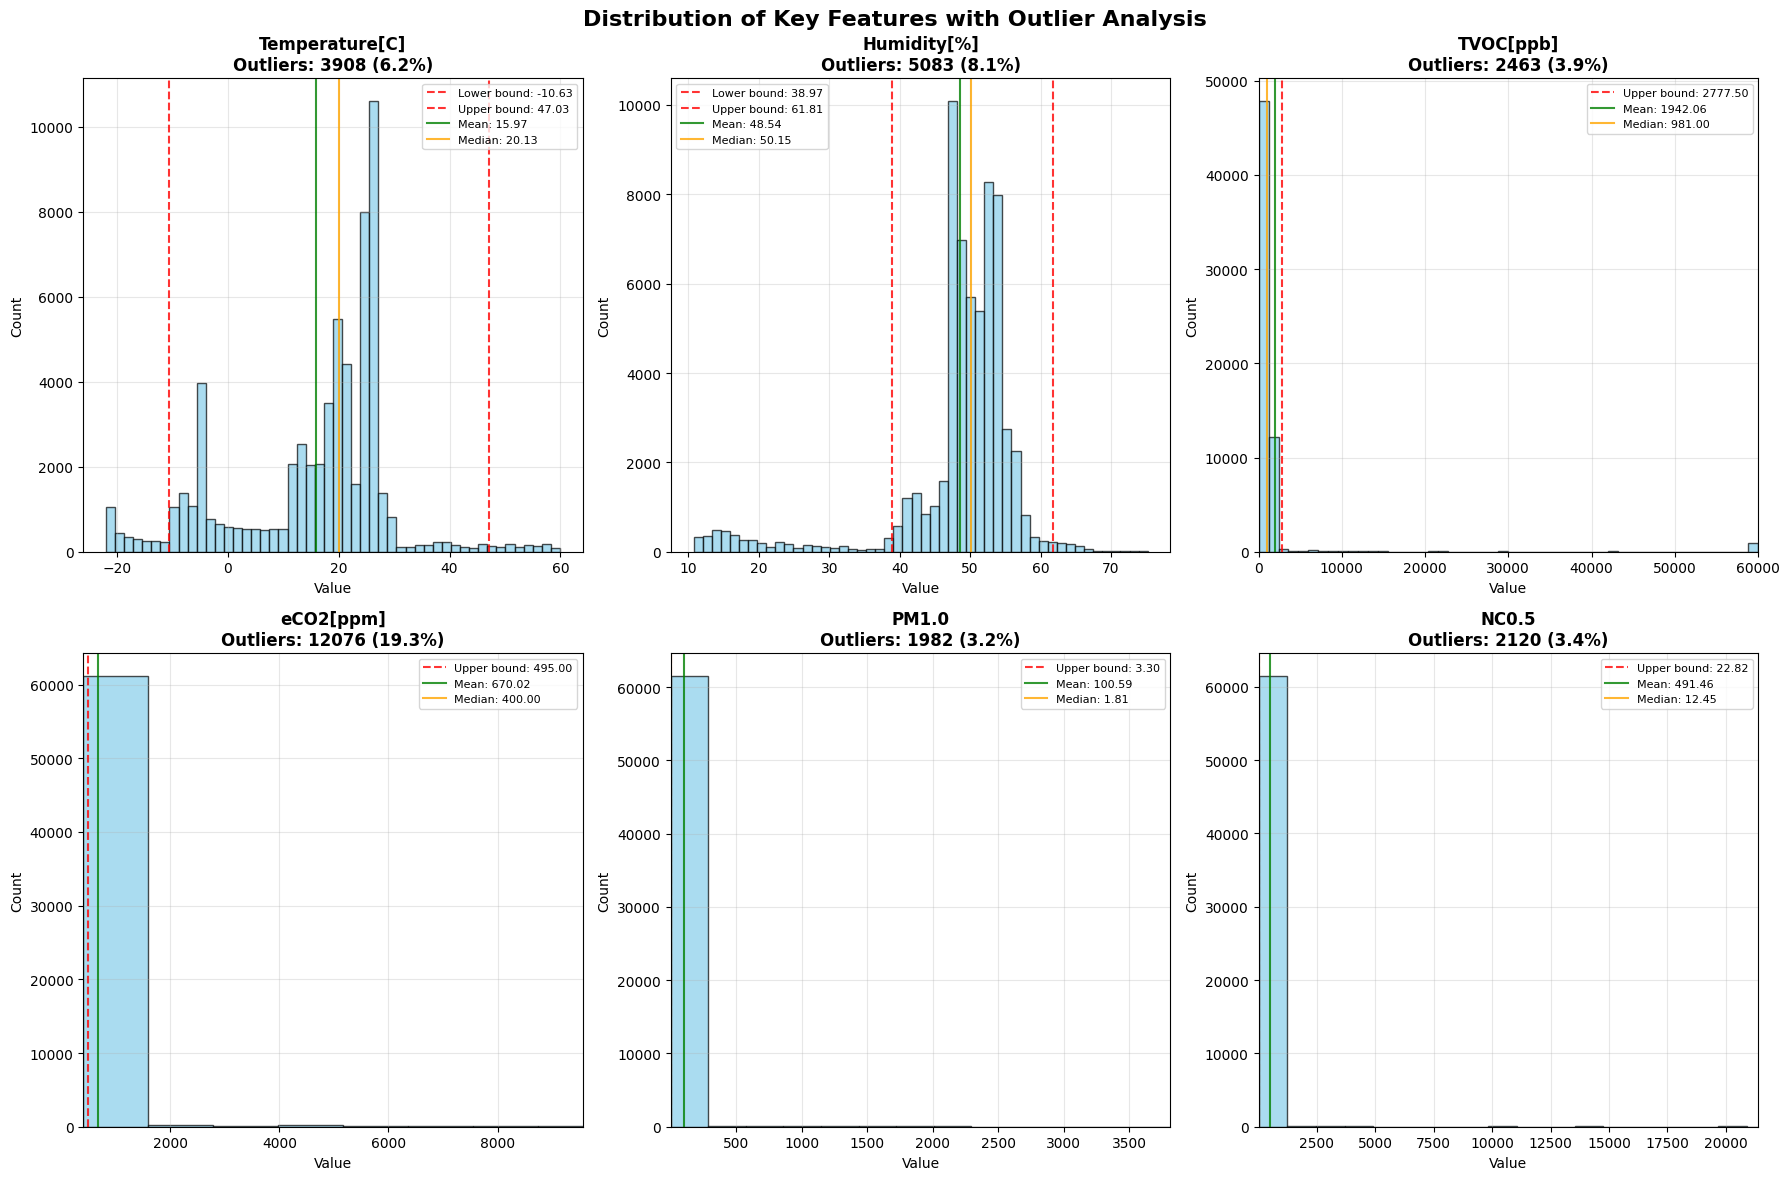

In [36]:
# Create distribution plots for key features with outlier detection and handling
def detect_outliers_iqr(data):
    """Detect outliers using IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

# Create subplots for the 6 key features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Key Features with Outlier Analysis', fontsize=16, fontweight='bold')

outlier_summary = []

for idx, feature in enumerate(available_key_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Get data for the feature
    feature_data = df_engineered[feature].dropna()
    
    # Detect outliers
    outliers, lower_bound, upper_bound = detect_outliers_iqr(feature_data)
    outlier_percentage = (len(outliers) / len(feature_data)) * 100
    
    # Store outlier information
    outlier_summary.append({
        'Feature': feature,
        'Total_Points': len(feature_data),
        'Outliers_Count': len(outliers),
        'Outlier_Percentage': outlier_percentage,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min_Value': feature_data.min(),
        'Max_Value': feature_data.max()
    })
    
    # Create histogram with count
    ax.hist(feature_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=False)
    
    # # Set better x-axis limits based on actual data range (with small padding)
    if feature in ['TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']:
        # Use 1st and 99th percentiles for better visualization
        p1 = feature_data.quantile(0.01)
        p99 = feature_data.quantile(0.99)
        ax.set_xlim(p1, p99)
    
    # Add vertical lines for outlier bounds (only if they're within the plot range)
    xlim = ax.get_xlim()
    if xlim[0] <= lower_bound <= xlim[1]:
        ax.axvline(lower_bound, color='red', linestyle='--', alpha=0.8, label=f'Lower bound: {lower_bound:.2f}')
    if xlim[0] <= upper_bound <= xlim[1]:
        ax.axvline(upper_bound, color='red', linestyle='--', alpha=0.8, label=f'Upper bound: {upper_bound:.2f}')
    
    # Add statistical information
    mean_val = feature_data.mean()
    median_val = feature_data.median()
    if xlim[0] <= mean_val <= xlim[1]:
        ax.axvline(mean_val, color='green', linestyle='-', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    if xlim[0] <= median_val <= xlim[1]:
        ax.axvline(median_val, color='orange', linestyle='-', alpha=0.8, label=f'Median: {median_val:.2f}')
    
    # Set labels and title
    ax.set_title(f'{feature}\nOutliers: {len(outliers)} ({outlier_percentage:.1f}%)', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Outlier Analysis for Some features

The previous plots revealed that 4 features have extreme outliers that distort their distributions:
- **TVOC[ppb]**: Normal range ~0-2,777, but outliers extend to 60,000
- **eCO2[ppm]**: Normal range ~0-495, but outliers extend to 60,000  
- **PM1.0**: Normal range ~0-3.3, but outliers extend to 14,333
- **NC0.5**: Normal range ~0-22.8, but outliers extend to 61,482

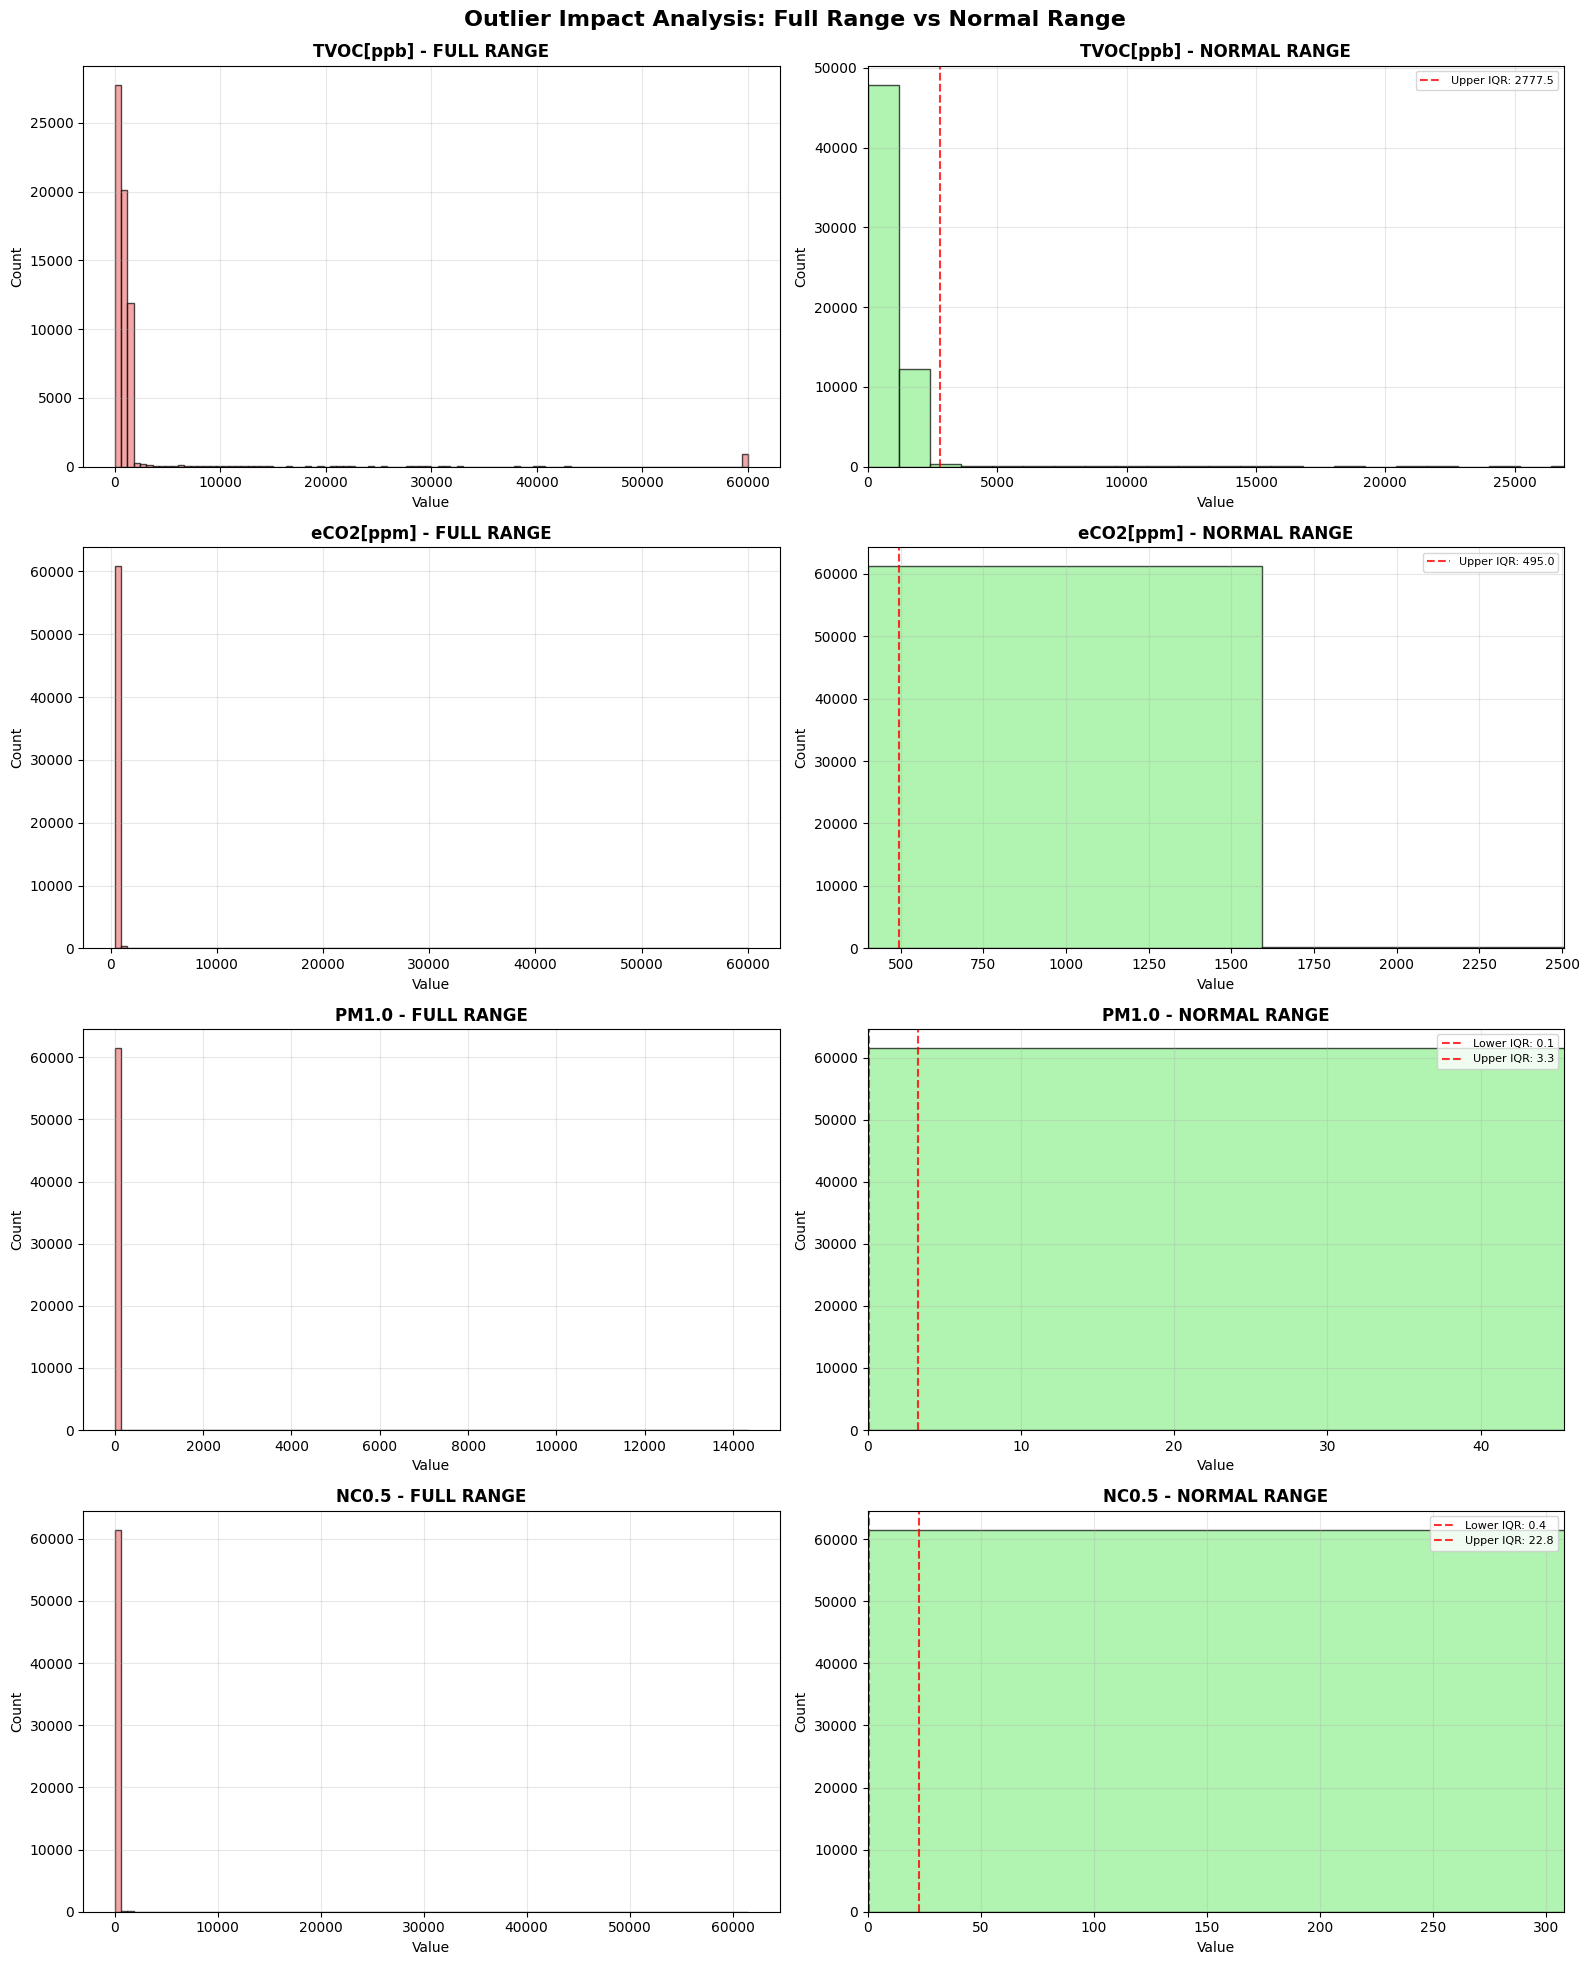

,Feature,Normal_Max,Actual_Max,Outlier_Count,Outlier_Percentage,Extreme_Outliers_99th,Range_Distortion
0,TVOC[ppb],2777.5,60000.0,2463,3.9%,0,21.6x
1,eCO2[ppm],495.0,60000.0,12076,19.3%,627,121.2x
2,PM1.0,3.3,14333.7,1982,3.2%,627,4337.0x
3,NC0.5,22.8,61482.0,2120,3.4%,627,2694.2x


In [37]:
# Deep analysis of the 4 features with extreme outliers
problematic_features = ['TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']

# Create comparison plots: Full range vs Normal range (without extreme outliers)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Outlier Impact Analysis: Full Range vs Normal Range\n', fontsize=16, fontweight='bold')

for idx, feature in enumerate(problematic_features):
    feature_data = df_engineered[feature].dropna()

    # Calculate outlier bounds
    outliers, lower_bound, upper_bound = detect_outliers_iqr(feature_data)
    
    # Calculate percentile ranges for better understanding
    p1 = feature_data.quantile(0)
    p98 = feature_data.quantile(0.98)
    
    # Left plot: Full range (showing the outlier problem)
    ax_full = axes[idx, 0]
    ax_full.hist(feature_data, bins=100, alpha=0.7, color='lightcoral', edgecolor='black')
    ax_full.set_title(f'{feature} - FULL RANGE', fontweight='bold')
    ax_full.set_xlabel('Value')
    ax_full.set_ylabel('Count')
    ax_full.grid(True, alpha=0.3)
    
    # Right plot: Normal range (1st to 99th percentile)
    ax_normal = axes[idx, 1]
    ax_normal.hist(feature_data, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    ax_normal.set_xlim(p1, p98)  # Focus on normal range
    ax_normal.set_title(f'{feature} - NORMAL RANGE', fontweight='bold')
    ax_normal.set_xlabel('Value')
    ax_normal.set_ylabel('Count')
    ax_normal.grid(True, alpha=0.3)
    
    # Add IQR bounds to normal range plot
    xlim = ax_normal.get_xlim()
    if xlim[0] <= lower_bound <= xlim[1]:
        ax_normal.axvline(lower_bound, color='red', linestyle='--', alpha=0.8, label=f'Lower IQR: {lower_bound:.1f}')
    if xlim[0] <= upper_bound <= xlim[1]:
        ax_normal.axvline(upper_bound, color='red', linestyle='--', alpha=0.8, label=f'Upper IQR: {upper_bound:.1f}')
    
    ax_normal.legend(fontsize=8)

plt.tight_layout()
plt.show()

summary_data = []
for feature in problematic_features:
    feature_data = df_engineered[feature].dropna()
    outliers, lower_bound, upper_bound = detect_outliers_iqr(feature_data)

    p99 = feature_data.quantile(0.99)
    
    # Calculate the ratio of extreme outliers
    extreme_outliers = feature_data[feature_data > p99]
    
    summary_data.append({
        'Feature': feature,
        'Normal_Max': f"{upper_bound:.1f}",
        'Actual_Max': f"{feature_data.max():.1f}", 
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': f"{len(outliers)/len(feature_data)*100:.1f}%",
        'Extreme_Outliers_99th': len(extreme_outliers),
        'Range_Distortion': f"{feature_data.max()/upper_bound:.1f}x"
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

## 4.3 Feature Relationships with Target

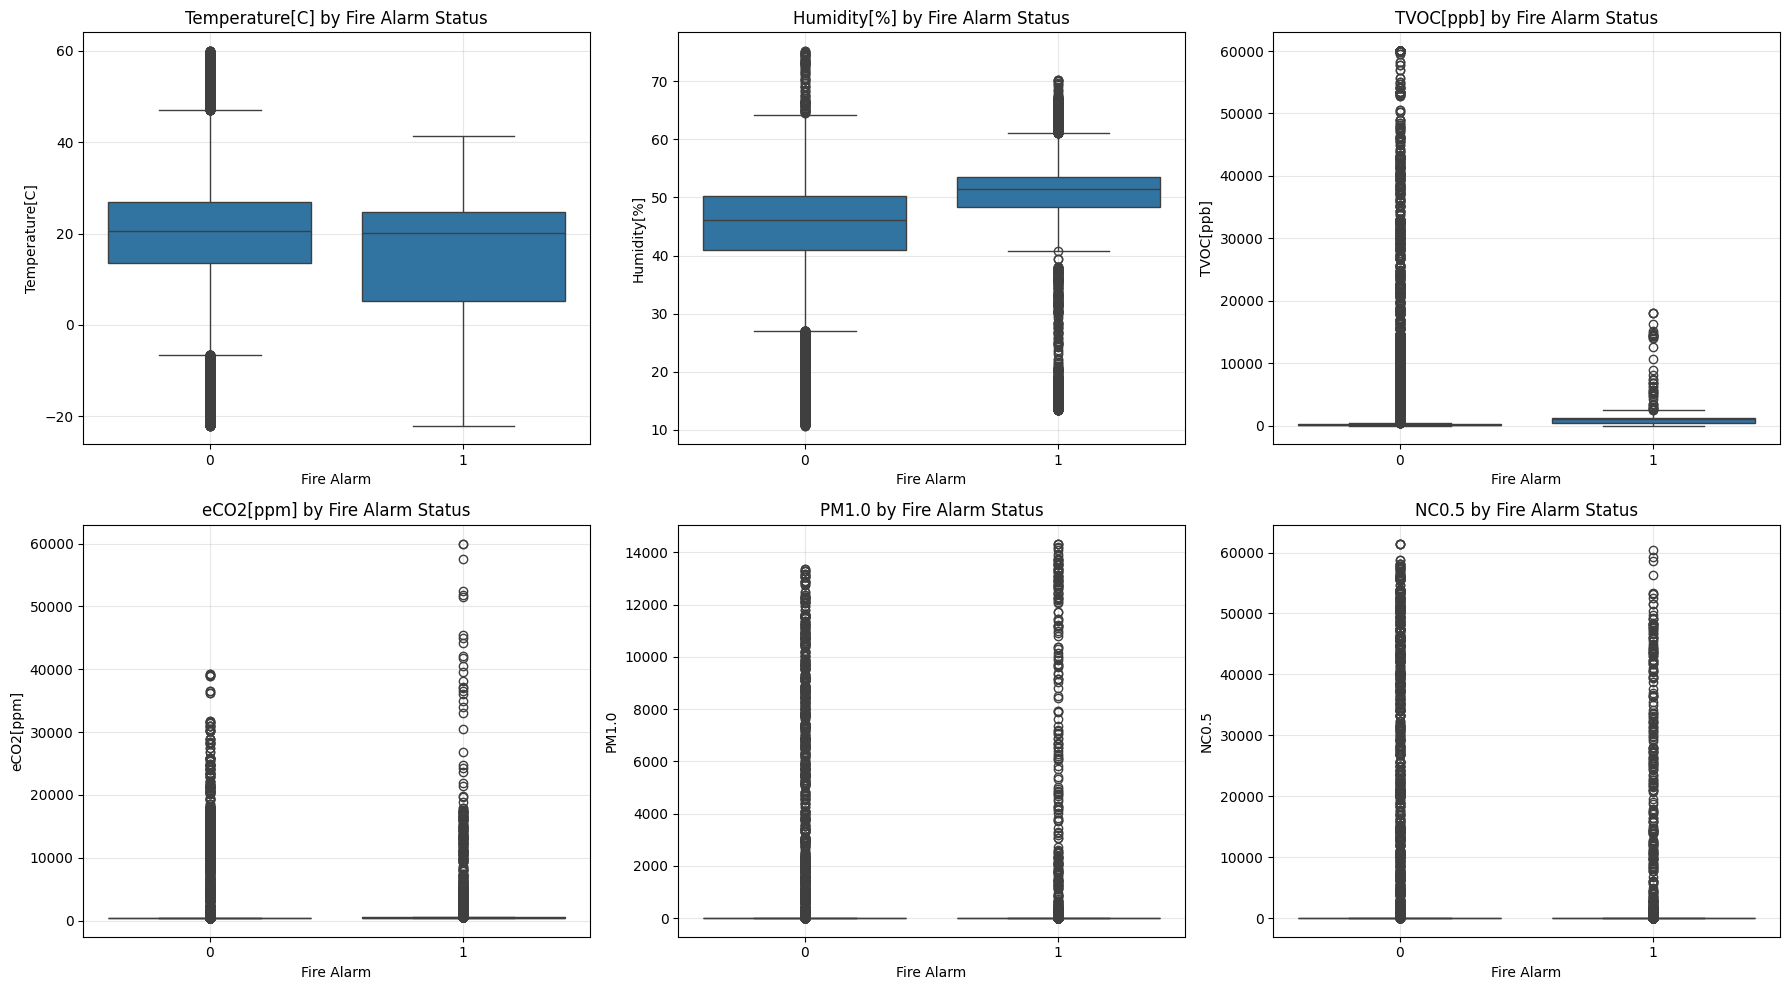

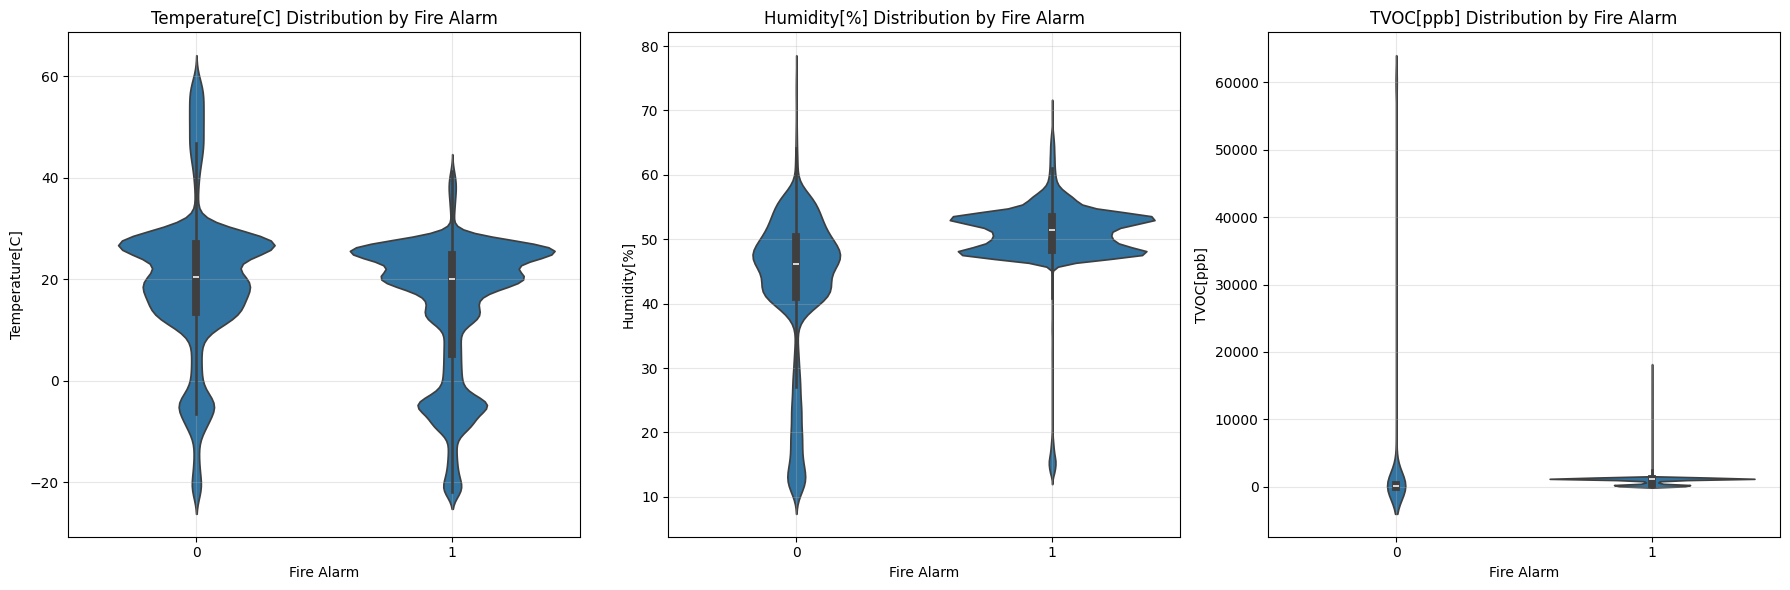

,Feature,P_Value,Significant,Median_No_Fire,Median_Fire,Median_Difference
1,Humidity[%],0.000000e+00,Yes,46.14,51.40,5.26
2,TVOC[ppb],0.000000e+00,Yes,86.00,1103.00,1017.00
3,eCO2[ppm],0.000000e+00,Yes,400.00,404.00,4.00
4,PM1.0,0.000000e+00,Yes,1.45,1.87,0.42
5,NC0.5,0.000000e+00,Yes,9.97,12.86,2.89
0,Temperature[C],8.638658e-250,Yes,20.54,20.02,-0.52



🔍 Statistically significant features (p < 0.05): 6
  • Humidity[%]
  • TVOC[ppb]
  • eCO2[ppm]
  • PM1.0
  • NC0.5
  • Temperature[C]


In [38]:
if target_col in df_engineered.columns:
    # Box plots for key features by target class
    key_features = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'NC0.5']
    available_features = [f for f in key_features if f in df_engineered.columns]
    
    if len(available_features) >= 4:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, feature in enumerate(available_features[:6]):
            if i < len(axes):
                sns.boxplot(data=df_engineered, x=target_col, y=feature, ax=axes[i])
                axes[i].set_title(f'{feature} by Fire Alarm Status')
                axes[i].grid(alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(available_features), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Violin plots for better distribution view
    if len(available_features) >= 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, feature in enumerate(available_features[:3]):
            sns.violinplot(data=df_engineered, x=target_col, y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} Distribution by Fire Alarm')
            axes[i].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    significance_results = []
    
    for feature in available_features:
        # Split data by target class
        no_fire = df_engineered[df_engineered[target_col] == 0][feature]
        fire = df_engineered[df_engineered[target_col] == 1][feature]
        
        if len(fire) > 0 and len(no_fire) > 0:
            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(no_fire, fire, alternative='two-sided')
            
            # Calculate effect size (difference in medians)
            median_diff = fire.median() - no_fire.median()
            
            significance_results.append({
                'Feature': feature,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                'Median_No_Fire': no_fire.median(),
                'Median_Fire': fire.median(),
                'Median_Difference': median_diff
            })
    
    if significance_results:
        sig_df = pd.DataFrame(significance_results)
        sig_df = sig_df.sort_values('P_Value')
        display(sig_df)
        
        # Identify most significant features
        significant_features = sig_df[sig_df['P_Value'] < 0.05]['Feature'].tolist()
        print(f"\n🔍 Statistically significant features (p < 0.05): {len(significant_features)}")
        for feature in significant_features:
            print(f"  • {feature}")
    
else:
    print("Target variable not found for relationship analysis")

## Extract the final dataset for modelling

In [ ]:
final_dataset = df_final.copy()

print(f"\n Remaining features ({len(final_dataset.columns)}):")
for i, col in enumerate(final_dataset.columns, 1):
    print(f"   {i:2d}. {col}")

output_filename = "smoke_detection_cleaned.csv"
final_dataset.to_csv(output_filename, index=False)

print(f"\nCleaned dataset saved as: {output_filename}")


 Remaining features (12):
    1. Temperature[C]
    2. Humidity[%]
    3. TVOC[ppb]
    4. eCO2[ppm]
    5. Raw H2
    6. Raw Ethanol
    7. Pressure[hPa]
    8. PM1.0
    9. NC0.5
   10. Fire Alarm
   11. Temp_Category
   12. Humidity_Category

Cleaned dataset saved as: smoke_detection_cleaned.csv

🚨 IMPORTANT NOTE ABOUT MODEL PERFORMANCE:
This dataset has TEMPORAL PATTERNS that create time-based clusters.
Random train/test splitting will give unrealistically high scores (99%+)
due to data leakage from temporal similarities.

For realistic evaluation:
✅ Use TEMPORAL SPLITTING (chronological train/test split)
✅ Keep the mixed scaling approach (RobustScaler + StandardScaler)
❌ Avoid random splitting for final model evaluation

The 'overfitting' observed is actually perfect temporal separation,
not true overfitting. Use temporal splits to get realistic metrics.

Cleaned dataset saved as: smoke_detection_cleaned.csv

🚨 IMPORTANT NOTE ABOUT MODEL PERFORMANCE:
This dataset has TEMPORAL PAT